## 04. PyTorch Custom Datasets Notebook

We.ve used data sets with PyTorch before but how do we get our own data into PyTorch?

Need to use custom datasets

## Domain Libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources**
* Book version of course materials: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebooks 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

In [86]:
import torch
from torch import nn

#Note PyTorch 1.10.0+ is required
torch.__version__

'2.3.0+cu121'

In [87]:
#set up device agnostic code
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Custom dataset link: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb

Why do This?

When starting ML projects it's important to try on a small scale and increase scale as necessary.

The whole point is to speed up how fast the experiment is.

In [88]:
import requests
import zipfile
from pathlib import Path

#setup path to data folder
data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"

#If image folder diesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists..skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True,exist_ok=True)

#Download pizza, steak and sushi data
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak and sushi data..")
  f.write(request.content)



#unzip pizza,sushi data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists..skipping download
Unzipping pizza, steak and sushi data...


## 2. Data preparation and data exploration (becming one with the data)

In [89]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [90]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza


In [91]:
# Setup train and testing paths
train_dir=image_path/"train"
test_dir=image_path/"test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing the image

Write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get image class name using `pathlib.Path.parent.stem`
4. Since we're working with images let's open the image with Python's PIL
5. We'll show the image and print metadata

data/pizza_steak_sushi/train/sushi/3360232.jpg
sushi
Random image path: data/pizza_steak_sushi/train/sushi/3360232.jpg
Image class: sushi
Image width: 512
Image height: 384


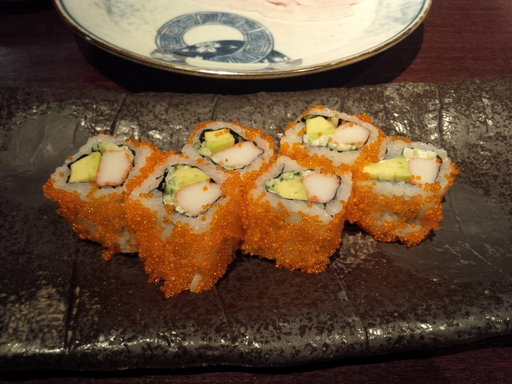

In [92]:
import random
from PIL import Image
#set seed
random.seed(42)

#1. Get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))

#image_path_list

#2. random image path
random_image_path=random.choice(image_path_list)

print(random_image_path)

#3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class=random_image_path.parent.stem
print(image_class)

#4.open image

img=Image.open(random_image_path)

#5. print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image width: {img.width}")
print(f"Image height: {img.height}")
img

(-0.5, 511.5, 383.5, -0.5)

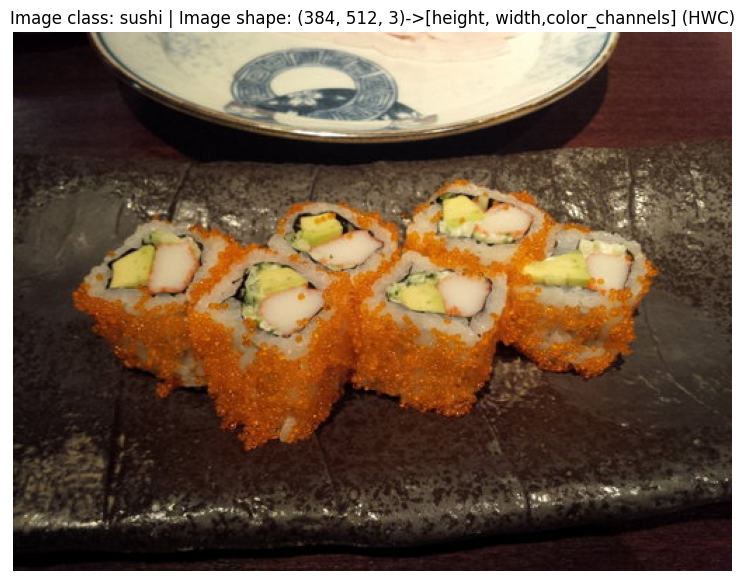

In [93]:
#Try to visualize the image with matplotlib
import numpy as np
import matplotlib.pyplot as plt
#turn image into an array
img_as_array=np.asarray(img)

#plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}->[height, width,color_channels] (HWC)")
plt.axis(False)

## 3.Transforming data

Before we can use our image data with PyTorch:

1. Turn target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.util.data.Dataset` and subsequently a `torch.utils.data.DataLoader`.

In [94]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get images ready to be used with a model/perform data augmentation-https://pytorch.org/vision/stable/transforms.html

In [95]:
from typing_extensions import dataclass_transform
#write a transform for an image
data_transform=transforms.Compose([
    #resize images to nintendo 64x64
    transforms.Resize(size=(64,64)),
    #Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn image into a torch.Tensor
    transforms.ToTensor()
])

data_transform(img).shape

torch.Size([3, 64, 64])

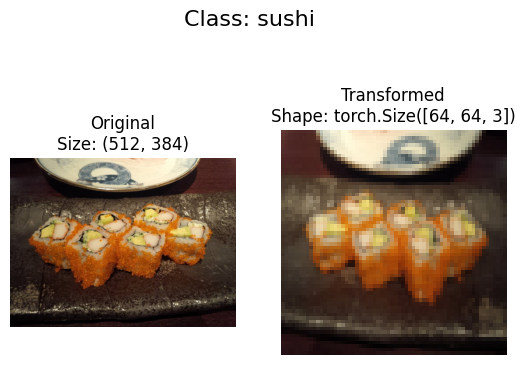

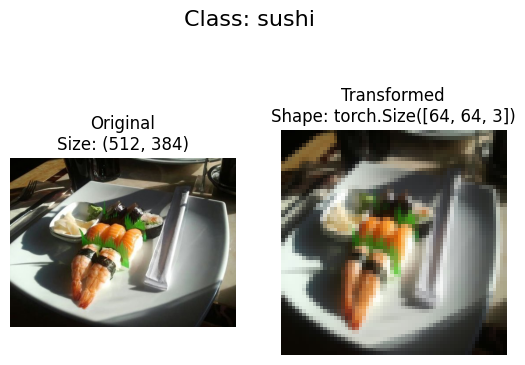

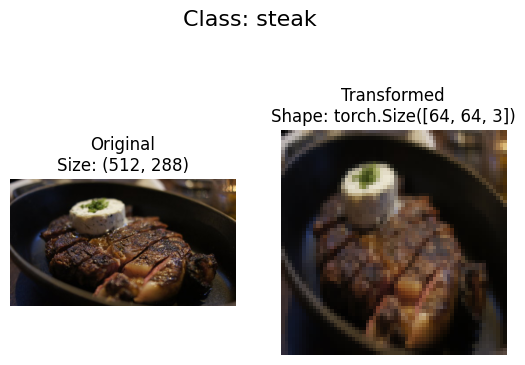

In [96]:
def plot_transformed_images(image_paths: list,transform,n=3,seed=42):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """

  if seed:
    random.seed(seed)
  random_image_paths=random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax=plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      #transform and plot target image
      transformed_image=transform(f).permute(1,2,0)#need to change shape for matplotlib; can use .permute to change order from (C,H,W)->(H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)


## 4. Option 1:Loading image data using `ImageFolder`

We can load image classification using `torchvision.datasets.ImageFolder` -https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [97]:
#Use Image Folder to create datasets
from torchvision import datasets
train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transform,# a transform for the data
                                target_transform=None)# a transform for the label/target

test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [98]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [99]:
#'get class names as a list'
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [100]:
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [101]:
#check the length of our dataset
len(train_data),  len(test_data)

(225, 75)

In [102]:
#Index on train_data Dataset to get a single image and label
img,label=train_data[0]
#class_names[label]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")#
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64])->[colour_chanels,hegiht,width]
Image permute: torch.Size([64, 64, 3])->[height, width,color_chanels]


Text(0.5, 1.0, 'pizza')

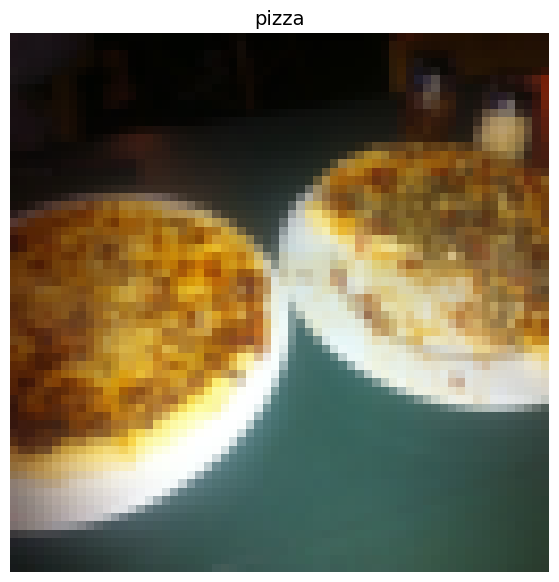

In [103]:
#Rearrange the order dimensions
img_permute=img.permute(1,2,0)

# print out different shapes
print(f"Original shape: {img.shape}->[colour_chanels,hegiht,width]")
print(f"Image permute: {img_permute.shape}->[height, width,color_chanels]")

#plt image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize=14)

## 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `datasets` into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [104]:
#Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
import os

BATCH_SIZE=1

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=os.cpu_count(),
                            shuffle=True)

test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=os.cpu_count(),
                           shuffle=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7921a2427040>,
 <torch.utils.data.dataloader.DataLoader at 0x7921a2426a40>)

Image shape: torch.Size([1, 3, 64, 64])->[batch_size, color_chanels,height,width]
Label shape: torch.Size([1])
img2 Shape: torch.Size([64, 64, 3])


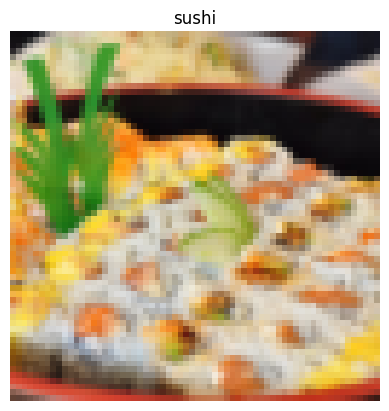

In [105]:
img, label=next(iter(train_dataloader))

#batch size will now be one, you can change as you wish
print(f"Image shape: {img.shape}->[batch_size, color_chanels,height,width]")
print(f"Label shape: {label.shape}")
#show sample
torch.manual_seed(42)
random_idx=torch.randint(0,len(img),size=[1]).item()
img2,label2=img[random_idx], label[random_idx]
plt.imshow(img2.squeeze().permute(1,2,0))#.squeeze()
plt.title(class_names[label2])
plt.axis(False)
print(f"img2 Shape: {img2.squeeze().permute(1,2,0).shape}")

## 5 Option 2: Loading Image Data with a custom `Dataset`

1. Want to be able to load image from file
2. Want to be able to get class names from the dataset
3. Want to be able to get classes as a dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it'll always work
* Using a custom `Dataset` often results in us writing more code, which could be prone to error or performance issues

All custom datasets in PyTorch often sublass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [106]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [107]:
#Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [108]:
target_directory=train_dir
print(f"Target dir: {target_directory}")
print(list(os.scandir(target_directory)))

#Get the class names from the target directory
class_names_found=sorted([entry.name for entry in list (os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train
[<DirEntry 'sushi'>, <DirEntry 'steak'>, <DirEntry 'pizza'>]


['pizza', 'steak', 'sushi']

In [109]:
def find_classes(directory: str)->Tuple[List[str],Dict[str,int]]:
  """Finds the class folder names in a target directory."""
  #1. Get class names by scanning the target directory
  classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  #2. rAISE AN ERROR IF CLASS NAMES COULD NOT BE FOUND
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}...please check file structure")

  #3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx={class_name: i for i,class_name in enumerate(classes)}
  return classes, class_to_idx

find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Sublass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform out data).
3. Create several attributes:
  * paths - paths of our image_class
  * transform - the transform we'd like to use
  * classes - a list of the target class_names
  * class_to_idx a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passes an index

In [110]:
#Write a custom dataset class
from torch.utils.data import Dataset

#1. Subclass torch.utiuls.data.Dataset
class ImageFolderCustom(Dataset):
  def __init__(self,targ_dir: str, transform=None):
    #3. Create class attribute
    #get all the image paths
    self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    #Setup transforms
    self.transform=transform
    #create classes and class_to_idx attributes
    self.classes, self.class_to_idx=find_classes(targ_dir)

  #4. Create a function to load images
  def load_image(self, index:int)->Image.Image:
    "Opens an image via a path and returns it."
    image_path=self.paths[index]
    return Image.open(image_path)

  #5. Overwrite __len__()
  def __len__(self)->int:
    "Returns the total number of samples"
    return len(self.paths)

  #6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X,y)."
    img=self.load_image(index)
    class_name=self.paths[index].parent.name #expects path in format data_folder/class_name/image.jpg
    class_idx=self.class_to_idx[class_name]

   #transform if necessary
    if self.transform:
      return self.transform(img), class_idx # returndata, label (X,y)
    else:
      return img, class_idx #return untransformed image and label


In [111]:
# Create a trainsfomr
from torchvision import transforms
train_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [112]:
# Test out ImageFolderCustom
train_data_custom=ImageFolderCustom(targ_dir=train_dir,
                                    transform=train_transforms)
test_data_custom=ImageFolderCustom(targ_dir=test_dir,
                                   transform=test_transforms)

In [113]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x79219da53400>,
 <__main__.ImageFolderCustom at 0x79219da537f0>)

In [114]:
len(train_data), len(train_data_custom), len(test_data), len(test_data_custom)

(225, 225, 75, 75)

In [115]:
train_data_custom.class_to_idx, train_data_custom.classes

({'pizza': 0, 'steak': 1, 'sushi': 2}, ['pizza', 'steak', 'sushi'])

In [116]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data.classes==train_data_custom.classes)
print(test_data.classes==test_data_custom.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, cap number of images to 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset
5. Setup matplotlib plot.
6. Loop through the random sample indexes and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [117]:
#1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n: int=10,
                          display_shape: bool=True,
                          seed: int=None):
  #2. Adjust display if n is too high
  if n> 10:
    n=10
    display_shape=False
    print(f"For display purposes, n shouldn't be parger than 10, setting to 10 and removing shape display")
  #3. Set random seef
  if seed:
    random.seed(seed)

  #4. Get random sample indexes
  random_samples_idx=random.sample(range(len(dataset)),k=n)

  #5.Setup plot
  plt.figure(figsize=(16,8))

  #6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label=dataset[targ_sample][0], dataset[targ_sample][1]

    #7. Adjust tensor dimensions for plotting
    targ_image_adjust=targ_image.permute(1,2,0) #[color_channels, height, width]->[height,width,color_channels]



    #8. Plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title=f"Class: {classes[targ_label]}"
      if display_shape:
        title=title+f"\nShape: {targ_image_adjust.shape}"
    plt.title(title)


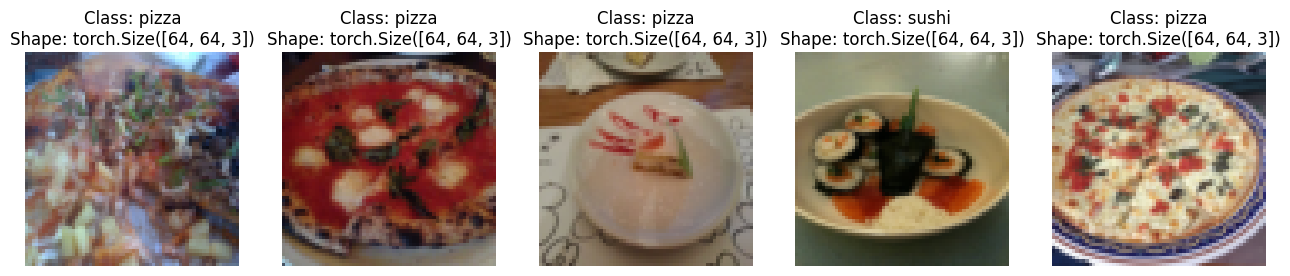

In [118]:
# display random images fromb the ImageFolder created datasst

display_random_images(dataset=train_data,
                      classes=train_data.classes,
                      n=5,
                      seed=None)

For display purposes, n shouldn't be parger than 10, setting to 10 and removing shape display


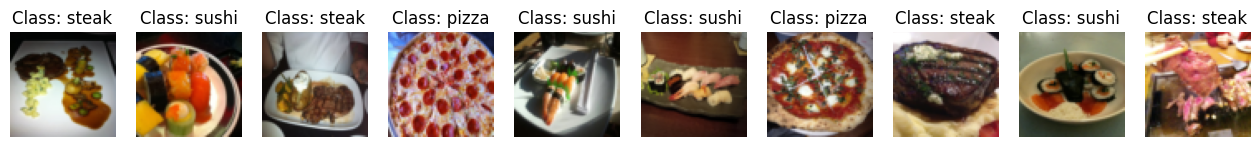

In [119]:
# Display random images from the ImageFolderCustom dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=test_data_custom.classes,
                      seed=7)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [120]:
#Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
import os

BATCH_SIZE=32

train_dataloader_custom=DataLoader(dataset=train_data_custom,
                            batch_size=BATCH_SIZE,
                            num_workers=os.cpu_count(),
                            shuffle=True)

test_dataloader_custom=DataLoader(dataset=test_data_custom,
                           batch_size=BATCH_SIZE,
                           num_workers=os.cpu_count(),
                           shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x79219b48e620>,
 <torch.utils.data.dataloader.DataLoader at 0x79219b48fd30>)

In [121]:
#Get image and label from custom dataloader
img_custom, label_custom=next(iter(train_dataloader_custom))
print(f"Image shape: {img_custom.shape}->[batch_size, color_chanels,height,width]")
print(f"Label shape: {label_custom.shape}")
#

Image shape: torch.Size([32, 3, 64, 64])->[batch_size, color_chanels,height,width]
Label shape: torch.Size([32])


## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of Image data, this may mean applying various image transformations to the training data.

This practise

Let's take a look at one particular type of data ugmentation used to train PyTorch vision models to state of the art levels.

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [122]:
#Let's look at trivailaugment -https://pytorch.org/vision/stable/auto_examples/
from torchvision import transforms

train_transform=transforms.Compose([
                transforms.Resize(size=(224,224)),
                transforms.TrivialAugmentWide(num_magnitude_bins=31),
                transforms.ToTensor()


])

test_transform=transforms.Compose([
                transforms.Resize(size=(224,224)),
                transforms.ToTensor()
])


In [123]:
#Get all image paths
image_path_list=list(data_path.glob("**/*.jpg"))
image_path_list[:10]

[PosixPath('data/04-pizza-dad.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2017378.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2590819.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1138695.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/929471.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1070104.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2574453.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1221830.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2120573.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3579071.jpg')]

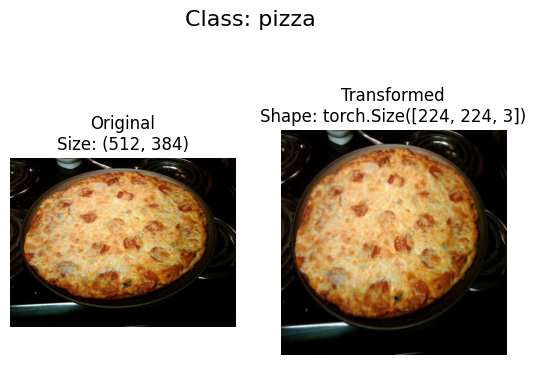

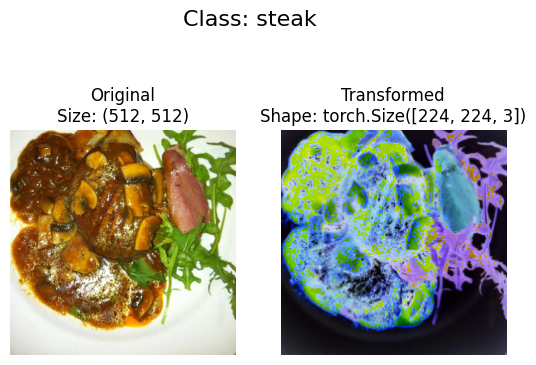

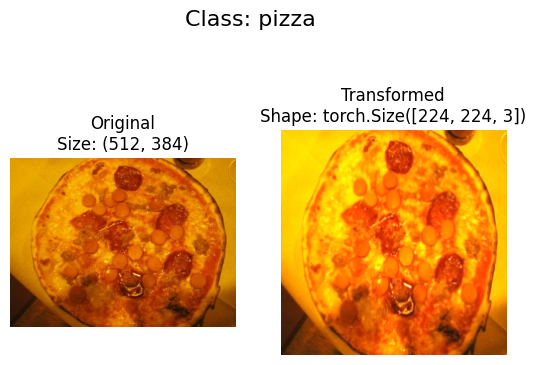

In [124]:
# Plot random transformed images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=7)

## 7. Model 0: TinyVGG without data augmentation

Lets' replicate TinyVGG architecture from CNN explainer website: https://poloclub.github.io/cnn-explainer/

### 7.1 Creating transforms and loading data for Model 0

In [125]:
#create a simple transform
simple_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [126]:
#1. Load and transform data
from torchvision import datasets
train_data_simple=datasets.ImageFolder(root=train_dir,
                                       transform=simple_transform)
test_data_simple=datasets.ImageFolder(root=test_dir,
                                      transform=simple_transform)

#2. Turn datasets into DataLoaders
import os
from torch.utils.data import DataLoader

#Setup batch size and number of workers
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

#Create DataLoader's
train_dataloader_simple=DataLoader(dataset=train_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True,
                                   num_workers=NUM_WORKERS)

test_dataloader_simple=DataLoader(dataset=test_data_simple,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False,
                                  num_workers=NUM_WORKERS)


## 7.2 Create TinyVGG model class

In [127]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN explainer website: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int)->None:
    super().__init__()
    self.conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) #default stride value same as kernel size
    )
    self.conv_block_2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) #default stride value same as kernel size
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)

      )

  def forward(self,x):
    x=self.conv_block_1(x)
    #print(x.shape) only for tests don't need when training on whole dataset
    x=self.conv_block_2(x)
    #print(x.shape) only for tests don't need when training on whole dataset
    x=self.classifier(x)
    #print(x.shape) only for tests don't need when training on whole dataset
    return x
    #return self.classifier(self.conv_block_2(self.conv_block_1(x))) benifits from operator fusion



In [128]:
torch.manual_seed(42)
model_0=TinyVGG(input_shape=3, #number of colour channels of our image
                hidden_units=10,
                output_shape=len(train_data_simple.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [129]:
image_batch, label_batch=next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [130]:
# try a forward pass
torch.manual_seed(42)
model_0(image_batch.to(device))
#imeError: mat1 and mat2 shapes cannot be multiplied (32x1690 and 10x3)
#2169 comes from multiplication of previous layer torch.Size([32, 10, 13, 13]) 13*13

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through the model

In [131]:
#Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model=model_0,
        input_size=image_batch.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

### 7.5 Create train and test loop functions

* `train_step()` - takes in a model and a dataloader and traions he model on a dataloader
* `test_step()` - takes in a model and a dataloader and evaluates on the model on a dataloader

In [132]:
#create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  #put model in train model
  model.train()

  #setup train lostt and train accuracy
  train_loss, train_acc=0,0

  #loop through data loader data batches
  for batch, (X,y) in enumerate(dataloader):
    #send data to the target device
    X,y=X.to(device), y.to(device)

    #1. forward pass
    y_pred=model(X)

    #2. calculate loss
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()

    #3. optimizer zero grad
    optimizer.zero_grad()

    #4. loss backwards
    loss.backward()

    #5. optimizer step
    optimizer.step()

    #calculate the accuracy metric
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  #adjust metrics to get average loss and accuracy per batch
  train_loss=train_loss/len(dataloader)
  train_acc=train_acc/len(dataloader)
  return train_loss, train_acc

In [133]:
#Create a test step function
#create train_step()
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
              device=device):
  #put model in eval model
  model.eval()

  #setup train lostt and train accuracy
  test_loss, test_acc=0,0

  #turn on inference mode
  with torch.inference_mode():

    #loop through data loader data batches
    for batch, (X,y) in enumerate(dataloader):
      #send data to the target device
      X,y=X.to(device), y.to(device)

      #1. forward pass
      test_pred_logits=model(X)

      #2. calculate loss
      loss=loss_fn(test_pred_logits,y)
      test_loss+=loss.item()

      #calculate the accuracy metric
      test_pred_labels=test_pred_logits.argmax(dim=1)
      test_acc+=(test_pred_labels==y).sum().item()/len(test_pred_labels)

  #adjust metrics to get average loss and accuracy per batch
  test_loss=test_loss/len(dataloader)
  test_acc=test_acc/len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step`

In [134]:
from tqdm.auto import tqdm

#1. Create a train function that takes in various model parameters + optimizers + dataloaders + loss function
def train(model:torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn: torch.nn.Module=nn.CrossEntropyLoss(),
          epochs: int=5,
          device=device):

  #2. Create an empty results dictionary
  results={ "train_loss": [],
           "train_acc": [],
            "test_loss": [],
            "test_acc": []}

  #3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc=train_step(model=model,
                                     dataloader=train_dataloader,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     device=device)
    test_loss, test_acc=test_step(model=model,
                                  dataloader=test_dataloader,
                                  loss_fn=loss_fn,
                                  device=device)

    #4. print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    #5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  #6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and evaluate model 0

In [135]:
#set random seeds
torch.manual_seed(42)
#torch.cuda.manual_seed(42)

#set number of epochs
NUM_EPOCHS=5

#recreate an instance on TinyVGGG
model_0=TinyVGG(input_shape=3, #numbr of inputs/color_channels
                hidden_units=10,
                output_shape=len(train_data.classes)).to(device)

#loss function
loss_fn=nn.CrossEntropyLoss()

#create optimizer
optimizer=torch.optim.Adam(params=model_0.parameters(),
                          lr=0.001)

#start the timer
from timeit import default_timer as timer
start_timer=timer()

#train model_0
model_0_results=train(model=model_0,
                      train_dataloader=train_dataloader_simple,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      device=device)

#end the timer and print out how long it took
end_timer=timer()
print(f"Total training time: {end_timer-start_timer:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0808 | Test acc: 0.4924
Epoch: 3 | Train loss: 1.0842 | Train acc: 0.3984 | Test loss: 1.0608 | Test acc: 0.5833
Epoch: 4 | Train loss: 1.0662 | Train acc: 0.4141 | Test loss: 1.0654 | Test acc: 0.5644
Total training time: 16.791 seconds


In [136]:
model_0_results

{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333137989044,
  1.0662163347005844],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.4140625],
 'test_loss': [1.0983205238978069,
  1.069690187772115,
  1.0807572205861409,
  1.0608317852020264,
  1.065395991007487],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

### 7.8 Plot the loss curves of Model 0

A **loss curve** is a way of tracking your model's training progress.

A good guide for different loss curves: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [137]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [138]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """
  Plots training and test loss curves of results dictionary
  """
  #get loss values of results dictionaary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  #get accuracy values of results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  #Figure out how many epochs there were
  epochs=range(len(results["train_loss"]))

  #Plot loss
  plt.figure(figsize= (15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

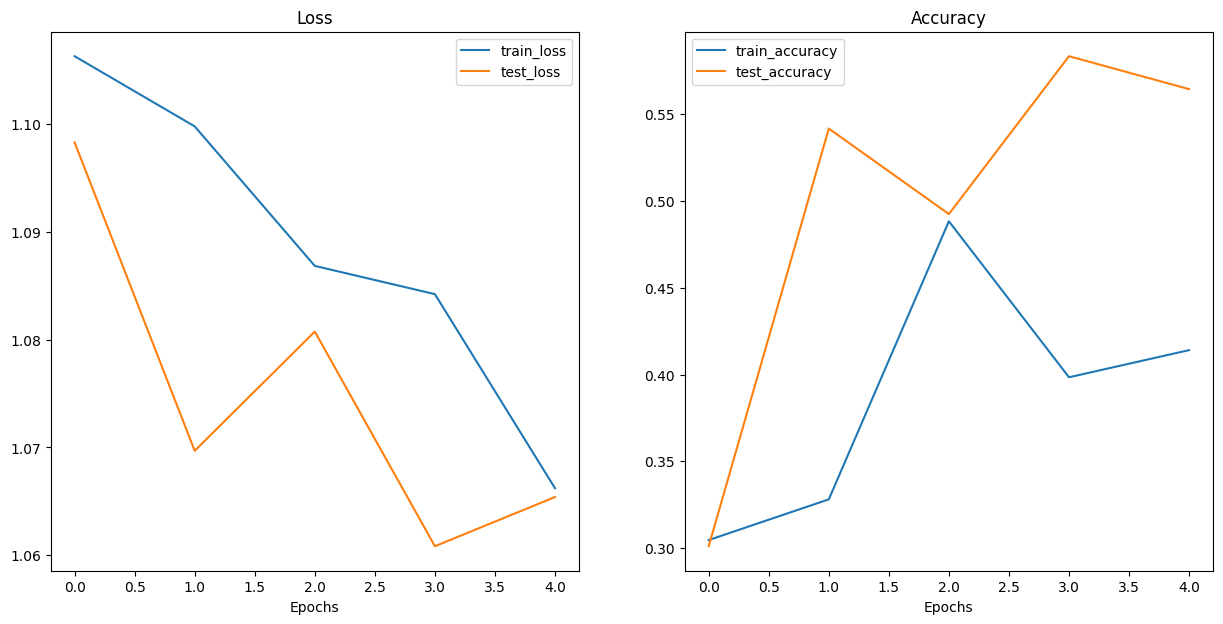

In [139]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve loos like?

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: TinyVGG with data augmentation

Now let's try another modelling experiment this time and using the same model as before with some data augmentation.

### 9.1 Create transform with data augmentation

In [140]:
#create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])


test_transform_simple=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset` and `DataLoader`'s with data augmentation

In [141]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented=datasets.ImageFolder(root=train_dir,
                                        transform=train_transform_trivial)
test_data_simple=datasets.ImageFolder(root=test_dir,
                                       transform=test_transform_simple)

In [142]:
#Turn our datasets into DataLoaders
import os
from torch.utils.data import DataLoader

#Setup batch size and number of workers
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented=DataLoader(dataset=train_data_augmented,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      num_workers=NUM_WORKERS)

test_dataloader_simple=DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1
"""
Model 1: TinyVGG with data augmentation
"""

In [143]:
#Create model_1 and send it to the target device
torch.manual_seed(42)
model_1=TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Noew we have a model and dataloaders we need a loss function and optimizer and call upon our `train()` function and evaluate our model

In [144]:
#set random seeds
torch.manual_seed(42)
#torch.cuda.manual_seed(42)

#set number of epochs
NUM_EPOCHS=5

#loss and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(),
                          lr=0.001)

#start timer
from timeit import default_timer as timer

start_timer=timer()

#train model 1

model_1_results=train(model=model_1,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      device=device)

#end tier and print out results
end_timer=timer()
print(f"Total training time: {end_timer-start_timer:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049 | Train acc: 0.2500 | Test loss: 1.1019 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.0807 | Train acc: 0.4258 | Test loss: 1.1261 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0712 | Train acc: 0.4258 | Test loss: 1.1593 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.1253 | Train acc: 0.3047 | Test loss: 1.1581 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0865 | Train acc: 0.4258 | Test loss: 1.1554 | Test acc: 0.3333
Total training time: 20.343 seconds


### 9.4 Plot the loss curves of model_1

A loss curve helps you evaluate your models performance

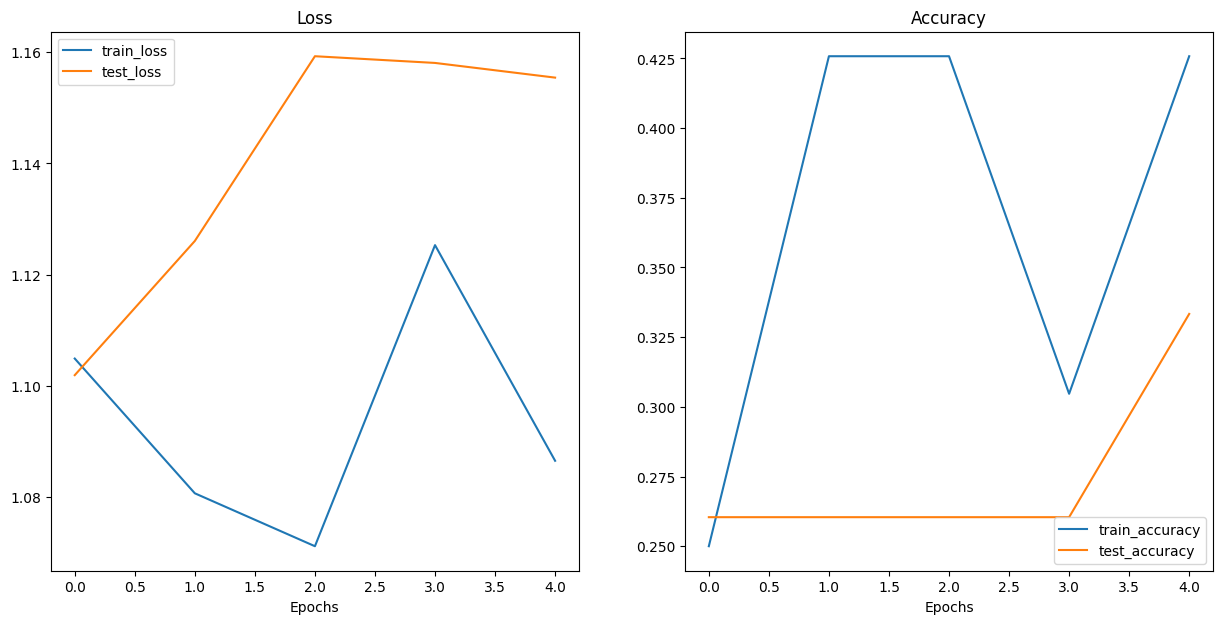

In [145]:
plot_loss_curves(model_1_results)

# 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways:
1. Hard coding (what we're doing)
2. PyTorch + Tensorboard -https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases -https://wandb.ai/site/experiment-tracking
4. MLFlow-https://mlflow.org/

In [146]:
import pandas as pd
model_0_df=pd.DataFrame(model_0_results)
model_1_df=pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.106319   0.304688   1.098321  0.301136
1    1.099806   0.328125   1.069690  0.541667
2    1.086854   0.488281   1.080757  0.492424
3    1.084233   0.398438   1.060832  0.583333
4    1.066216   0.414062   1.065396  0.564394

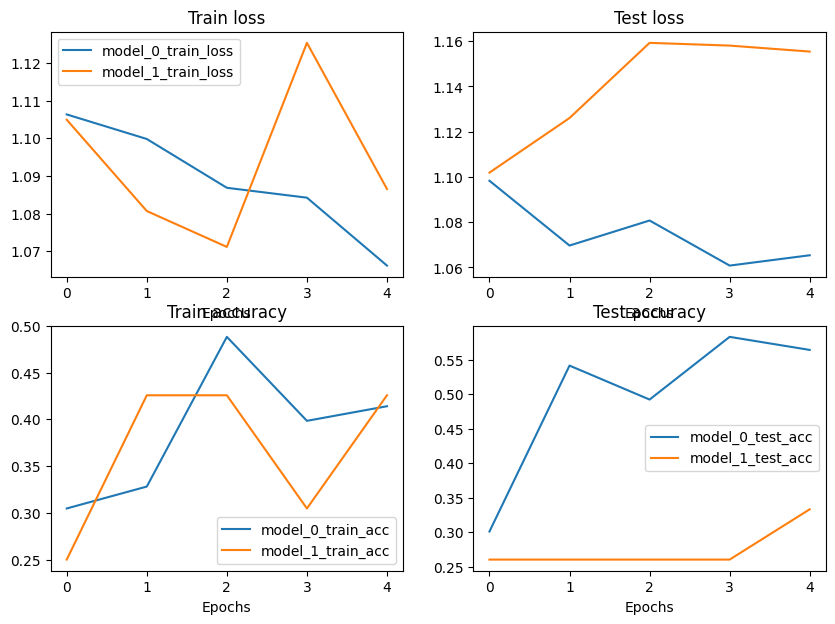

In [147]:
#Setup a plot
plt.figure(figsize=(10,7))

#get epoch number
epochs=range(len(model_0_df))

#plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="model_0_train_loss")
plt.plot(epochs, model_1_df["train_loss"], label="model_1_train_loss")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()


#plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="model_0_test_loss")
plt.plot(epochs, model_1_df["test_loss"], label="model_1_test_loss")
plt.title("Test loss")
plt.xlabel("Epochs")
plt
#plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="model_0_train_acc")
plt.plot(epochs, model_1_df["train_acc"], label="model_1_train_acc")
plt.title("Train accuracy")
plt.xlabel("Epochs")
plt.legend()

#plot test accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="model_0_test_acc")
plt.plot(epochs, model_1_df["test_acc"], label="model_1_test_acc")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.legend()

## 11. Making a prediction on a custom image

Although we've trained a model on custom data..how do you make a prediction on a smple/image that's not in either the traiing or testing dataset.

In [148]:
#download custom image
import requests

#setup custom image path
custom_image_path=data_path/"04-pizza-dad.jpg"

#download the image if it doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

data/04-pizza-dad.jpg already exists, skipping download...


### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in te same format as the data our model was trainined on.

* In tensor form with datatype (torch.float32)
* In shape 64x64x3
* On the right device

We can read in image into PyTorch using:https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [149]:
import torchvision

#read in custom image
custom_image_unit8=torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_unit8}")
print(f"Custom image shape: {custom_image_unit8.shape}")
print(f"Custom image datatype: {custom_image_unit8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

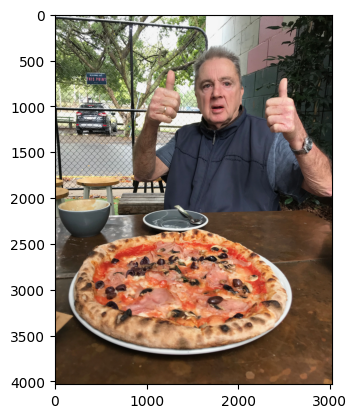

In [150]:
plt.imshow(custom_image_unit8.permute(1,2,0))

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [151]:
#try to make a prediction on an image  in uint8 format
model_1.eval()
with torch.inference_mode():
  custom_image_float32=custom_image_unit8.type(torch.float32)
  custom_image_float32_device=custom_image_float32.to(device)

  #divide by number of colour channels 255 to make tensor values between 0 and 1
  custom_image_float32_device/=255.

In [152]:
#create transform comspose to resize the image
custom_image_transform=transforms.Compose([
    transforms.Resize(size=(64,64))#,
    #transforms.ToTensor()
])

#Transform target image
custom_image_transformed=custom_image_transform(custom_image_float32_device)

#print out the shape
print(f"Original shape: {custom_image_unit8.shape}")
print(f"New shape: {custom_image_transformed.shape}")
print(f"New Type: {custom_image_transformed.dtype}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])
New Type: torch.float32


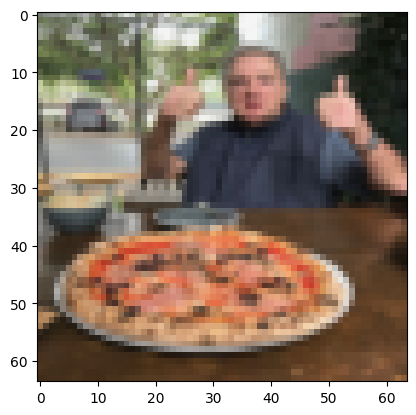

In [153]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [154]:
#This will error as there's no batch size
# model_1.eval()
# with torch.inference_mode():
#   custom_image_pred=model_1(custom_image_transformed.to(device))

In [155]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [156]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred=model_1(custom_image_transformed.unsqueeze(0).to(device))

custom_image_pred

tensor([[ 0.0780,  0.0379, -0.2067]])

Note to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3,64,64) with a batch size->(1,3,64,64)
* Make sure image on same device as our model

In [157]:
# CONVERT logits->prediction probabilities
custom_image_pred_probs=torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3686, 0.3541, 0.2773]])

In [158]:
#Convert prediction probabilities -> prediction labels
custom_image_pred_labels=torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_labels

tensor([0])

In [159]:
class_names[custom_image_pred_labels]

'pizza'

### 11.3 Putting a custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [167]:
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str]=None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with trained model and plots the image and predictions"""

  #load image
  target_image=torchvision.io.read_image(str(image_path)).type(torch.float32).to(device)

  #divide the image pixel value by 255 to get between 0,1
  target_image=target_image/255.

  #transform image
  if transform:
    target_image=transform(target_image)

  #make sure model to target device
  model.to(device)

  #make prediction
  model.eval()
  with torch.inference_mode():
    target_image=target_image.unsqueeze(0)
    target_image_pred=model(target_image).to(device)

  #conver logits-> prediction probs
  target_image_pred_probs=torch.softmax(target_image_pred, dim=1)

  #convert prediction probs->prediction labels
  target_image_pred_label=torch.argmax(target_image_pred_probs, dim=1)

  #plt the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1,2,0)) #remove batch dimension and change so colour channels last
  if class_names:
    title=f"Prediction: {class_names[target_image_pred_label.to(device)]} | Probability: {target_image_pred_probs.max().item():.2f}"

  else:
    title=f"Prediction: {target_image_pred_label} | Probability: {target_image_pred_probs.max().item():.2f}"
  plt.title(title)
  plt.axis(False)

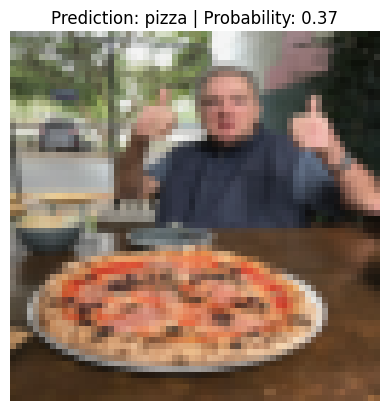

In [168]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                   image_path=custom_image_path,
                   class_names=class_names,
                   transform=custom_image_transform,
                    device=device)

## Exercises

for all exercises and extra see here: https://www.learnpytorch.io/04_pytorch_custom_datasets/

In [169]:
import torch

print(torch.__version__)

device= "gpu" if torch.cuda.is_available() else "cpu"
device

2.3.0+cu121


'cpu'

####1. Prevent underfitting

1. Add more layers/units to your model (increase model complexity). This will potentially give the model more of an opportunity to learn generalizable patterns in the training data. For example, instead of using 2 hidden layers, use 4 hidden layers instead.

2.Use transfer learning. Transfer leanring helps to prevent underfitting by leveraging already existing/working patterns from one model/dataset and using them with your own problem.

3. Train the model for longer. Perhaps your initial training schedule didn't give your model enough opportunity to learn patterns in the data. Training your model for longer (more epochs) may give improved results.

####2. Dataloading and should have `DataLoader`'s ready

In [171]:
#1. Get Data
import requests
import zipfile
from pathlib import Path

#set up data folder
data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"

#if the image folder doesn't exist, download it

if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Downloading {image_path}...")
  image_path.mkdir(parent=True,exist_ok=True)

#Download pizza, steak sushi from github
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downlading image of pizza steak suchi")
  f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  zip_ref.extractall(image_path)
  print(f"unzipping my pizza steak sushi into {image_path}")



data/pizza_steak_sushi directory exists.
Downlading image of pizza steak suchi
unzipping my pizza steak sushi into data/pizza_steak_sushi


In [172]:
#2 check the dir paths and everything bro
import os
def walk_through_PSS(dir_path):
  """Walks through the directory and counts files"""
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

walk_through_PSS(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.


In [173]:
#set up train and test dirs
test_dir=image_path/"test"
train_dir=image_path/"train"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

[PosixPath('data/pizza_steak_sushi/train/sushi/2017378.jpg'), PosixPath('data/pizza_steak_sushi/train/sushi/2590819.jpg'), PosixPath('data/pizza_steak_sushi/train/sushi/1138695.jpg')]
data/pizza_steak_sushi/train/sushi/3360232.jpg
steak
Random image path: data/pizza_steak_sushi/train/sushi/3360232.jpg
Image class: steak
Image height: 384
Image width: 512


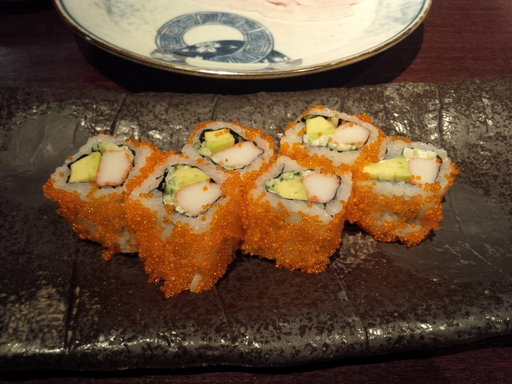

In [175]:
import random
from PIL import Image

#set seed
random.seed(77)

#get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))
print(image_path_list[:3])


#get random image path
random_image=random.choice(image_path_list)
print(random_image_path)

#class name
image_class=random_image.parent.stem
print(image_class)

img=Image.open(random_image_path)

#print meta data
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

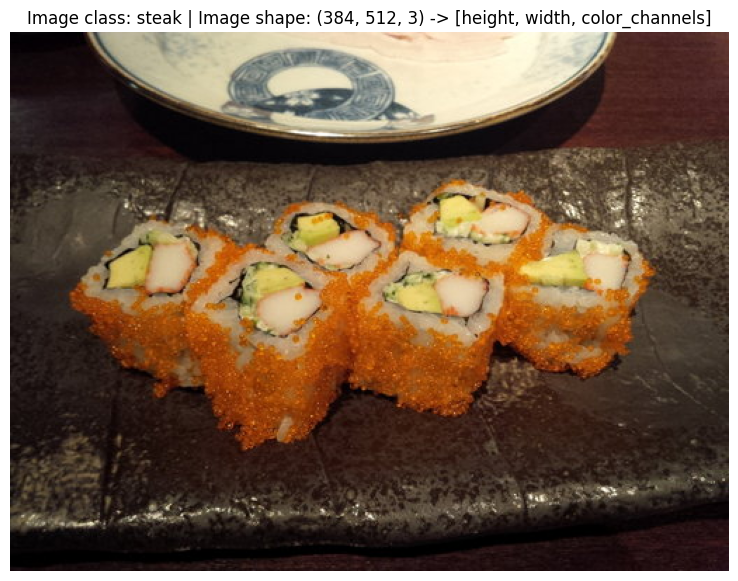

In [176]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

Now we need to make them compatible with PyTorch by:

Transform the data into tensors.
Turn the tensor data into a torch.utils.data.Dataset and later a torch.utils.data.DataLoader.

In [177]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

PSS_transform=transforms.Compose([
    #resize image to 64,64
    transforms.Resize((64,64)),
    #random flip image fur funzies
    transforms.RandomHorizontalFlip(p=0.3),
    #convert to tensor
    transforms.ToTensor() #conert all pixels values from 0-255 to between 0-1
])

In [178]:
random.sample(image_path_list, k=3)

[PosixPath('data/pizza_steak_sushi/train/pizza/244505.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/100135.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2648423.jpg')]

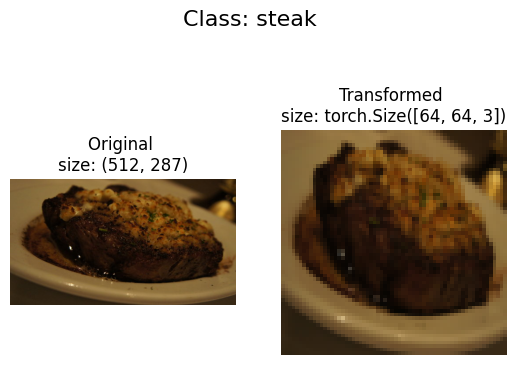

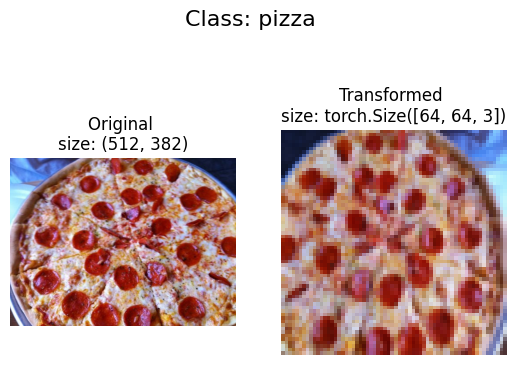

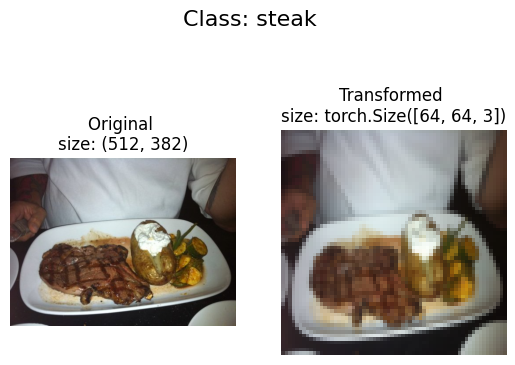

In [179]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=77):
  """Plots a series of random images from image_paths."""
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nsize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      # permute() the image to make sure it's compatible with matplotlib
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nsize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,transform=PSS_transform,n=3)

In [180]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=PSS_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=PSS_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.3)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.3)
                ToTensor()
            ))

In [181]:
# Get class names as a list
class_names = train_data.classes
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [182]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7921b1f229b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7921b1f23490>)

In [183]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


####3. Recreate a mdoel for the pizza steak sushi

In [209]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape))

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(f"Layer 1 shape: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Layer 2 shape: {x.shape}")
    x = self.classifier(x)
    #print(f"Layer 3 shape: {x.shape}")
    return x

In [210]:
model_0 = TinyVGG(input_shape = 3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [211]:
# Pass dummy data through model
dummy_x = torch.rand(size=[1, 3, 64, 64])
#mat1 and mat2 shapes cannot be multiplied (1x2560 and 10x3) check insides of matrices
model_0(dummy_x.to(device))

tensor([[ 0.0121, -0.0188,  0.0054]], grad_fn=<AddmmBackward0>)

####4. Create train and test functions

In [212]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

  #pit model into train mode
  model.train()

  #set up loss and acc
  train_loss, train_acc = 0, 0

  #loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    #1. Do the forward pass
    y_pred=model(X)

    #2. Calculate the loss and accumulate
    loss=loss_fn(y_pred, y)
    train_loss+=loss.item()

    #3. Optimizer zero grad
    optimizer.zero_grad()

    #4. Loss backward
    loss.backward()

    #5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [213]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)
      # print(test_pred_logits)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [214]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

In [215]:
# Train for 5 epochs
torch.manual_seed(77)
#torch.cuda.manual_seed(77)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1038 | train_acc: 0.3467 | test_loss: 1.0803 | test_acc: 0.3333
Epoch: 2 | train_loss: 0.9950 | train_acc: 0.4978 | test_loss: 0.9912 | test_acc: 0.4800
Epoch: 3 | train_loss: 0.9196 | train_acc: 0.5600 | test_loss: 0.9697 | test_acc: 0.5067
Epoch: 4 | train_loss: 0.8806 | train_acc: 0.5689 | test_loss: 0.9855 | test_acc: 0.4133
Epoch: 5 | train_loss: 0.8236 | train_acc: 0.6444 | test_loss: 1.0010 | test_acc: 0.4400
Epoch: 6 | train_loss: 0.8146 | train_acc: 0.6489 | test_loss: 0.9983 | test_acc: 0.5200
Epoch: 7 | train_loss: 0.7816 | train_acc: 0.6622 | test_loss: 0.9702 | test_acc: 0.4400
Epoch: 8 | train_loss: 0.7332 | train_acc: 0.6667 | test_loss: 1.1194 | test_acc: 0.4667
Epoch: 9 | train_loss: 0.7649 | train_acc: 0.6444 | test_loss: 1.0001 | test_acc: 0.4267
Epoch: 10 | train_loss: 0.6804 | train_acc: 0.7156 | test_loss: 1.0299 | test_acc: 0.4667


In [216]:
# Train for 20 epochs
torch.manual_seed(77)
torch.cuda.manual_seed(77)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1038 | train_acc: 0.3467 | test_loss: 1.0803 | test_acc: 0.3333
Epoch: 2 | train_loss: 0.9950 | train_acc: 0.4978 | test_loss: 0.9912 | test_acc: 0.4800
Epoch: 3 | train_loss: 0.9196 | train_acc: 0.5600 | test_loss: 0.9697 | test_acc: 0.5067
Epoch: 4 | train_loss: 0.8806 | train_acc: 0.5689 | test_loss: 0.9855 | test_acc: 0.4133
Epoch: 5 | train_loss: 0.8236 | train_acc: 0.6444 | test_loss: 1.0010 | test_acc: 0.4400
Epoch: 6 | train_loss: 0.8146 | train_acc: 0.6489 | test_loss: 0.9983 | test_acc: 0.5200
Epoch: 7 | train_loss: 0.7816 | train_acc: 0.6622 | test_loss: 0.9702 | test_acc: 0.4400
Epoch: 8 | train_loss: 0.7332 | train_acc: 0.6667 | test_loss: 1.1194 | test_acc: 0.4667
Epoch: 9 | train_loss: 0.7649 | train_acc: 0.6444 | test_loss: 1.0001 | test_acc: 0.4267
Epoch: 10 | train_loss: 0.6804 | train_acc: 0.7156 | test_loss: 1.0299 | test_acc: 0.4667
Epoch: 11 | train_loss: 0.6608 | train_acc: 0.6933 | test_loss: 1.1049 | test_acc: 0.4533
Epoch: 12 | train_l

In [217]:
####6. Double hidden inits ans see how results effected
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(77)
torch.cuda.manual_seed(77)
model_3 = TinyVGG(input_shape=3,
                  hidden_units=20, # use 20 hidden units instead of 10
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20) # train for 20 epochs

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1066 | train_acc: 0.3511 | test_loss: 1.0755 | test_acc: 0.4533
Epoch: 2 | train_loss: 1.0460 | train_acc: 0.5333 | test_loss: 0.9974 | test_acc: 0.4800
Epoch: 3 | train_loss: 0.9139 | train_acc: 0.5556 | test_loss: 1.0252 | test_acc: 0.5733
Epoch: 4 | train_loss: 0.9535 | train_acc: 0.5733 | test_loss: 1.0059 | test_acc: 0.5067
Epoch: 5 | train_loss: 0.8409 | train_acc: 0.6444 | test_loss: 1.0257 | test_acc: 0.5067
Epoch: 6 | train_loss: 0.8466 | train_acc: 0.6267 | test_loss: 0.9596 | test_acc: 0.4800
Epoch: 7 | train_loss: 0.8142 | train_acc: 0.6489 | test_loss: 0.9962 | test_acc: 0.4400
Epoch: 8 | train_loss: 0.7327 | train_acc: 0.6667 | test_loss: 1.0058 | test_acc: 0.4800
Epoch: 9 | train_loss: 0.7410 | train_acc: 0.6844 | test_loss: 1.1890 | test_acc: 0.4667
Epoch: 10 | train_loss: 0.6873 | train_acc: 0.7067 | test_loss: 1.0148 | test_acc: 0.4933
Epoch: 11 | train_loss: 0.6668 | train_acc: 0.6889 | test_loss: 1.0002 | test_acc: 0.4667
Epoch: 12 | train_l

####7. Double the data we're using and train for 20 epochs

In [218]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [219]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

train_data_20_percent = ImageFolder(train_data_20_percent_path,
                                    transform=simple_transform)

test_data_20_percent = ImageFolder(test_data_20_percent_path,
                                   transform=simple_transform)

# Create dataloaders
train_dataloader_20_percent = DataLoader(train_data_20_percent,
                                         batch_size=32,
                                         num_workers=os.cpu_count(),
                                         shuffle=True)

test_dataloader_20_percent = DataLoader(test_data_20_percent,
                                        batch_size=32,
                                        num_workers=os.cpu_count(),
                                        shuffle=False)

In [220]:
# Train a model with increased amount of data
torch.manual_seed(77)
torch.cuda.manual_seed(77)
model_4 = TinyVGG(input_shape=3,
                  hidden_units=20, # use 20 hidden units instead of 10
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader_20_percent, # use double the training data
                        test_dataloader=test_dataloader_20_percent, # use double the testing data
                        optimizer=optimizer,
                        epochs=20) # train for 20 epochs

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1018 | train_acc: 0.3375 | test_loss: 1.0851 | test_acc: 0.3563
Epoch: 2 | train_loss: 1.0528 | train_acc: 0.4875 | test_loss: 1.0101 | test_acc: 0.4761
Epoch: 3 | train_loss: 0.9107 | train_acc: 0.5625 | test_loss: 0.9322 | test_acc: 0.5483
Epoch: 4 | train_loss: 0.8553 | train_acc: 0.6083 | test_loss: 0.8769 | test_acc: 0.6227
Epoch: 5 | train_loss: 0.8162 | train_acc: 0.6646 | test_loss: 0.8929 | test_acc: 0.5824
Epoch: 6 | train_loss: 0.8372 | train_acc: 0.6083 | test_loss: 0.8760 | test_acc: 0.5335
Epoch: 7 | train_loss: 0.8090 | train_acc: 0.6438 | test_loss: 0.8637 | test_acc: 0.6733
Epoch: 8 | train_loss: 0.7412 | train_acc: 0.6687 | test_loss: 0.8422 | test_acc: 0.6068
Epoch: 9 | train_loss: 0.7042 | train_acc: 0.6854 | test_loss: 0.8883 | test_acc: 0.6386
Epoch: 10 | train_loss: 0.6498 | train_acc: 0.7104 | test_loss: 0.8548 | test_acc: 0.5830
Epoch: 11 | train_loss: 0.5862 | train_acc: 0.7708 | test_loss: 0.8762 | test_acc: 0.5818
Epoch: 12 | train_l

####8. Make a prediction on a custom image

In [221]:
# Get a custom image
custom_image = "pizza_dad.jpeg"
with open("pizza_dad.jpeg", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
  f.write(request.content)

In [222]:
# Load the image
import torchvision
img = torchvision.io.read_image(custom_image)
img

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

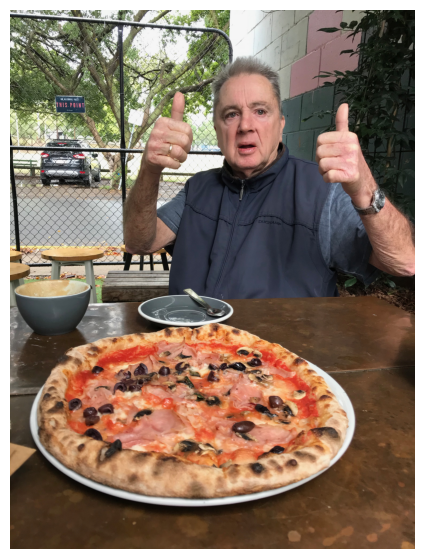

In [223]:
# View the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in HWC (height, width, color_channels) format not CHW (color_channels, height, width)
plt.axis(False);

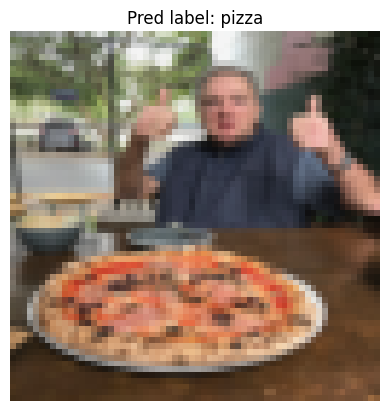

In [224]:
# Make a prediction on the image
model_4.eval()
with torch.inference_mode():
  # Get image pixels into float + between 0 and 1
  img = img / 255.

  # Resize image to 64x64
  resize = transforms.Resize((64, 64))
  img = resize(img)

  # Turn image in single batch and pass to target device
  batch = img.unsqueeze(0).to(device)

  # Predict on image
  y_pred_logit = model_4(batch)

  # Convert pred logit to pred label
  # pred_label = torch.argmax(torch.softmax(y_pred_logit, dim=1), dim=1)
  pred_label = torch.argmax(y_pred_logit, dim=1) # get same results as above without torch.softmax

# Plot the image and prediction
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False);